In [1]:
#import pandas_summary as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVD, SlopeOne, NMF,KNNBasic
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
#Reading the data
anime_df = pd.read_csv("dataset/anime.csv")
rating_df = pd.read_csv('dataset/rating.csv')

In [3]:
print('anime dataset: ', anime_df.shape)
print('rating dataset: ', rating_df.shape)

anime dataset:  (12294, 7)
rating dataset:  (7813737, 3)


In [4]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
#Merging two dataframes
data = rating_df.merge(anime_df, how='left', left_on=['anime_id'], right_on=['anime_id'])
df = data[data['rating_x'] != -1]
df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
47,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892.0
81,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660.0
83,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0
101,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657.0
153,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315.0


In [17]:
#pick the data entry which has anime_id with number of ratings greater than 230,
#user with number of ratings greater than 250

num_ratings = 230
anime = df['anime_id'].value_counts() > num_ratings
anime = anime[anime].index.tolist()

num_user_ratings = 250
users = df['user_id'].value_counts() > num_user_ratings
users = users[users].index.tolist()

df_filtered = df[(df['anime_id'].isin(anime)) & (df['user_id'].isin(users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_filtered.shape))

The original data frame shape:	(6337241, 9)
The new data frame shape:	(2382574, 9)


In [18]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_filtered[['user_id', 'anime_id', 'rating_x']], reader)

In [18]:
#Analyzing algorithms to check their test_rmse
metric = []
for algorithm in [SVD(biased=False), KNNBasic(),SlopeOne(), NMF()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    result_df = pd.DataFrame.from_dict(results).mean(axis=0)
    result_df = result_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    metric.append(result_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [20]:
surprise_results = pd.DataFrame(metric).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.107101,71.475460,7.605750
SlopeOne,1.156540,48.301180,356.963701
KNNBasic,1.158559,113.829034,675.652523
NMF,2.108311,279.958908,22.579880


From the results we can conclude that SVD provides better results for this dataset, as the test_rmse is lowest for SVD compared to other algorithms.

In [7]:
#Import required libraries
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [8]:
#Drop all null values
anime_df = anime_df.dropna()
#Change unknown "episode" values to 0.
anime_df.loc[anime_df["episodes"] == "Unknown", "episodes"] = 0
anime_df["episodes"] = anime_df["episodes"].astype(int)

In [9]:
anime_dataset = pd.merge(anime_df,rating_df[["user_id","anime_id","rating"]], on = ["anime_id"],how = "right")
anime_dataset.rename(columns = {'rating_x':'average_rating','rating_y':'rating'}, inplace = True)
anime_dataset.dropna(inplace=True)

anime_dataset.head()

,anime_id,name,genre,type,episodes,average_rating,members,user_id,rating
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297.0,1,-1
1,24,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553.0,1,-1
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772.0,1,-1
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511.0,1,-1
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395.0,1,-1


In [10]:
anime_rating_freq = anime_dataset.groupby(by='anime_id').count()['rating'].reset_index().rename(columns={'rating':'rating_count'})

In [11]:
anime = anime_rating_freq[anime_rating_freq['rating_count']>250]

In [12]:
anime.head()

,anime_id,rating_count
0,1,15509
1,5,6927
2,6,11077
3,7,2629
4,8,413


In [13]:
user = anime_dataset.groupby(by='user_id').count()['rating'].reset_index().rename(columns={'rating':'rating_count'})
user['rating_count'].describe()

count    73515.000000
mean       106.285942
std        153.074216
min          1.000000
25%         18.000000
50%         57.000000
75%        136.000000
max      10225.000000
Name: rating_count, dtype: float64

In [14]:
filtered_user = user[user['rating_count']>100]
filtered_user.head()

,user_id,rating_count
0,1,153
4,5,467
6,7,343
10,11,112
12,13,174


In [15]:
filtered_rating_anime = anime_dataset[anime_dataset['anime_id'].isin(anime['anime_id'])]
filtered_rating = filtered_rating_anime[filtered_rating_anime['user_id'].isin(filtered_user['user_id'])]

In [16]:
# this is the filtered dataset containing most watched and rated animes
filtered_rating.head()

,anime_id,name,genre,type,episodes,average_rating,members,user_id,rating
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297.0,1,-1
1,24,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553.0,1,-1
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772.0,1,-1
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511.0,1,-1
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395.0,1,-1


In [17]:
rating_matrix = filtered_rating.pivot_table(index='user_id',columns='name',values='rating').fillna(0)
print(rating_matrix.shape)
rating_matrix.head()

(24676, 3318)


name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X = rating_matrix.T

In [19]:
svd = TruncatedSVD(n_components = 14, random_state = 42)
resultant_matrix = svd.fit_transform(X)
resultant_matrix.shape

(3318, 14)

In [20]:
correlation_matrix = np.corrcoef(resultant_matrix)
correlation_matrix.shape

(3318, 3318)

In [21]:
def func(name):
    display(name)
    return name

column = rating_matrix.columns
choice = interactive(func, name = widgets.Dropdown(options= column, value='Naruto' ,description='Anime Title:',disabled=False))
print("Select an Anime: ")
display(choice)

Select an Anime: 


interactive(children=(Dropdown(description='Anime Title:', index=2049, options=('&quot;Bungaku Shoujo&quot; Ky…

In [25]:
anime_title = choice.result
column_index = rating_matrix.columns.get_loc(anime_title)
correlation = correlation_matrix[column_index]

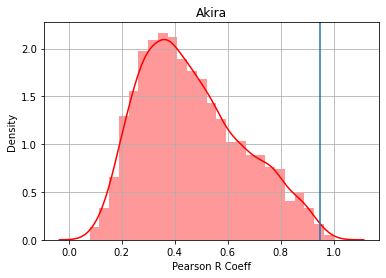

In [26]:
plt.grid(True)
sns.distplot(correlation, color="red", axlabel='Pearson R Coeff').set(title = anime_title)
plt.axvline(0.95, 0,3.5)
plt.show()

In [27]:
print("Recommendations for {}:".format(choice.result))
list(rating_matrix.columns[(correlation<1.0) & (correlation > 0.95)])

Recommendations for Akira:


['Cowboy Bebop',
 'Cowboy Bebop: Tengoku no Tobira',
 'Ghost in the Shell',
 'Ghost in the Shell 2: Innocence',
 'Jin-Rou',
 'Juubee Ninpuuchou',
 'Mousou Dairinin',
 'Steamboy',
 'The Animatrix']

The above out means, the people who have watched 'Akira' have also watched the anime from the above list, and these are the animes which are similar to the Akira. So if the user has watched Akira previously, these could be the potential list of animes to watch in the future.